Ningaloo Nino in the model, obs and ctrl

In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask

In [2]:
from eofs.xarray import Eof

In [3]:
#import dask to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [4]:
print(client)

<Client: 'tcp://127.0.0.1:34353' processes=4 threads=8, memory=22.46 GiB>


In [5]:
po_pace_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/sst.nc", chunks = {"time":12})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [6]:
ctrl_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/ctrl_sst.nc", chunks = {'time':12})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [7]:
po_pace_sst = po_pace_sst.sel(time = slice('0955-01-16','1100-12-16' ))

In [8]:
ctrl_sst = ctrl_sst.sel(time = slice('0955-01-16','1100-12-16' ))

In [9]:
def regrid_ACCESS(ds):
    #rename coords
    ds = ds.rename({"geolon_t": "longitude", "geolat_t": "latitude"})
    #create the output grid
    ds_out = xe.util.grid_global(1, 1)
    ds_out = ds_out.drop({'lon_b', 'lat_b'})
    #rename grid coords
    ds_out = ds_out.rename({'lon': 'longitude', 'lat': 'latitude'})
    #drop the coords on input ds
    ds_in_1deg = ds.drop({'xt_ocean', 'yt_ocean'})
    #create regridder
    regridder_1deg = xe.Regridder(ds_in_1deg, ds_out, 'bilinear', periodic=True)
    #now regrid
    regridded = regridder_1deg(ds['sst'].chunk({'xt_ocean': -1, 'yt_ocean': -1}))
    regridded = regridded.assign_coords({'x': ds_out.longitude[0, :], 'y': ds_out.latitude[:, 0]})
    regridded = regridded.rename({'x': 'longitude', 'y': 'latitude'})
    return regridded

In [10]:
%%time
PO_PACE = regrid_ACCESS(po_pace_sst)

CPU times: user 19.3 s, sys: 2.56 s, total: 21.8 s
Wall time: 23.8 s


In [11]:
%%time
PO_PACE = PO_PACE.compute()

CPU times: user 7.73 s, sys: 2.03 s, total: 9.76 s
Wall time: 54.7 s


In [12]:
%%time
ctrl = regrid_ACCESS(ctrl_sst)

CPU times: user 12.6 s, sys: 230 ms, total: 12.8 s
Wall time: 11.7 s


In [13]:
%%time
ctrl = ctrl.compute()

CPU times: user 8.62 s, sys: 1.97 s, total: 10.6 s
Wall time: 1min 5s


In [14]:
oc_pace_sst = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/obs_c_sst.nc", chunks = {"time":12})

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [15]:
OC = regrid_ACCESS(oc_pace_sst)

In [16]:
OC = OC.compute()

In [17]:
#get subset of each and do eof

In [18]:
OC_IO = OC.sel(latitude=slice(-30, 30),longitude=slice(40, 120))
MC_IO = PO_PACE.sel(latitude=slice(-30, 30),longitude=slice(40, 120))
ctrl_IO = ctrl.sel(latitude=slice(-30, 30),longitude=slice(40, 120))

In [46]:
def eof_plot(sst):
    coslat = np.cos(np.deg2rad(sst.coords['latitude'].values))
    wgts = np.sqrt(coslat)[..., np.newaxis]
    solver = Eof(sst, weights=wgts)
    
    # Retrieve the leading EOF, expressed as the correlation between the leading
    # PC time series and the input SST anomalies at each grid point, and the
    # leading PC time series itself.
    eof1 = solver.eofsAsCorrelation(neofs=4)
    pc1 = solver.pcs(npcs=1, pcscaling=1)
    
    # Plot the leading EOF expressed as correlation in the Pacific domain.
    clevs = np.linspace(-1, 1, 11)
    #ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=190))
    #fill = eof1[0].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
    #                             add_colorbar=False, transform=ccrs.PlateCarree())

    eof1.plot.contourf(col='mode', col_wrap = 2, transform=ccrs.PlateCarree(),
                                 subplot_kws={"projection": ccrs.PlateCarree()}, levels = 12)
    return

In [50]:
ctrl_IO

<xarray.DataArray (time: 1752, latitude: 60, longitude: 80)>
array([[[24.340351, 24.512827, 24.467518, ...,       nan,       nan,
               nan],
        [24.976635, 25.21935 , 25.246647, ...,       nan,       nan,
               nan],
        [25.649323, 25.846212, 25.996077, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[26.119272, 26.441063, 26.444248, ...,       nan,       nan,
               nan],
        [26.917551, 27.33117 , 27.44957 , ...,       nan,       nan,
               nan],
        [27.80447 , 28.175642, 28.423334, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[23.611382, 23.803715, 23.854773, ...,       nan,       nan,
               nan],
        [24.302628, 24.673115, 24.898397, ...,       nan,       nan,
               nan],
        [24.837936, 25.268671, 25.589035, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * time       (time) object 0955-01-16 12:00:00 ... 1100-12-15 12:00:00
  * longitude  (longitude) float64 40.5 41.5 42.5 43.5 ... 117.5 118.5 119.5
  * latitude   (latitude) float64 -29.5 -28.5 -27.5 -26.5 ... 27.5 28.5 29.5
Attributes:
    regrid_method:  bilinear

In [51]:
eof_plot(ctrl_IO.groupby('time.year').mean('time').rename("year)

ValueError: cannot find a time coordinate (must be called "time", have a numpy.datetime64 dtype, or have an attribute named "axis" with value "T")

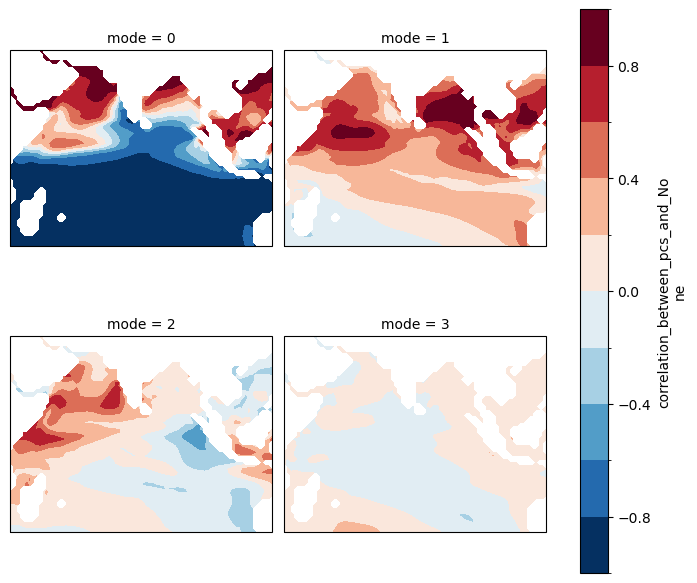

In [48]:
eof_plot(MC_IO)

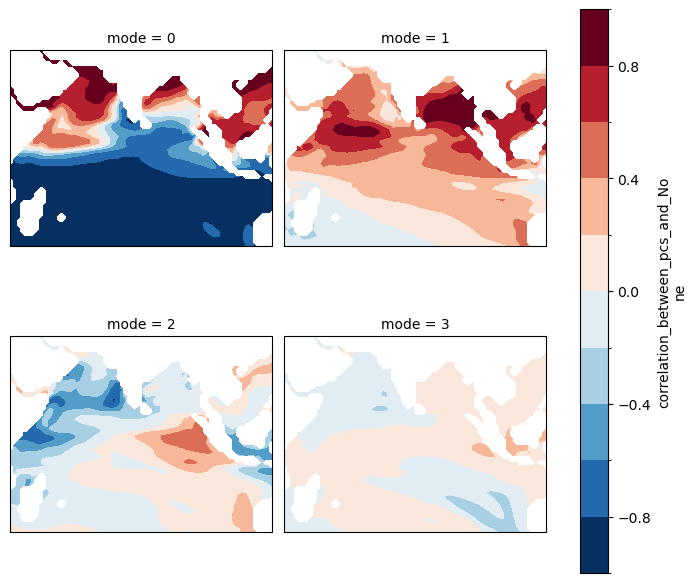

In [49]:
eof_plot(OC_IO)

In [32]:
test

<xarray.DataArray 'eofs' (mode: 1, latitude: 60, longitude: 80)>
array([[[-0.93291056, -0.925953  , -0.92248666, ...,         nan,
                 nan,         nan],
        [-0.92830306, -0.92223895, -0.9191392 , ...,         nan,
                 nan,         nan],
        [-0.923486  , -0.91905516, -0.9153356 , ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * mode       (mode) int64 0
  * latitude   (latitude) float64 -29.5 -28.5 -27.5 -26.5 ... 27.5 28.5 29.5
  * longitude  (longitude) float64 40.5 41.5 42.5 43.5 ... 117.5 118.5 119.5
Attributes:
    long_name:  correlation_between_pcs_and_None

In [14]:
#load observational SST
OBS = xr.open_dataset("/g/data/e14/sm2435/ACCESS_PIctrl/oisstv2.nc", chunks = {'time':12}).sst
#rename coords
OBS = OBS.rename({"lon": "longitude", "lat": "latitude"})
OBS = OBS.compute()

In [15]:
#load the lsm
lsm = xr.open_dataset("/g/data/e14/sm2435/ACCESS_PIctrl/oisstv2_lsm.nc").mask
#rename coords
lsm = lsm.rename({"lon": "longitude", "lat": "latitude"})


In [16]:
OBS = OBS.where(lsm[0]==1)

In [17]:
#load observational SST
ersstv5 = xr.open_dataset("/g/data/e14/sm2435/PO_model_clim/ersstv5.nc", chunks = {'time':12}).sst
#rename coords
ersstv5 = ersstv5.rename({"lon": "longitude", "lat": "latitude"})
ersstv5 =ersstv5.sel(time = slice("1980-01-01", "2020-12-31"))
ersstv5 = ersstv5.compute()

In [18]:
def plot_latlon(ds1, ds2, lat, lon):
    if lon < 0:
        lon = 360+lon
    ds1 = ds1.sel(latitude = lat, longitude = lon, method = 'nearest')
    ds2 = ds2.sel(latitude = lat, longitude = lon, method = 'nearest')
    #make figure:
    fig,axes  = plt.subplots(1,1,figsize = (16, 4),sharex=True, sharey=True)

    ds1.sel(time = slice('0951-01-16','1104-01-16' )).groupby('time.year').mean('time').plot(ax = axes, c = 'tab:blue', label = 'Pace')
    ds2.sel(time = slice('0951-01-16','1104-01-16' )).groupby('time.year').mean('time').plot(ax = axes,c = 'tab:orange', label = 'ctrl')
    axes.legend()
    #axes[0].plot(ds1.sel(time = slice('0951-01-16','1104-01-16' )))
    #axes[1].plot(ds2.sel(time = slice('0951-01-16','1104-01-16' )))
    return fig

In [19]:
def get_djf_mn(ds):
    djf = ds.resample(time="QS-DEC").mean()
    djf = djf.sel(time=djf['time.season']=='DJF')
    return djf

In [20]:
def get_mam_mn(ds):
    mam = ds.resample(time="QS-MAR").mean()
    mam = mam.sel(time=mam['time.season']=='MAM')
    return mam
    #return ds.sel(time=ds['time.month'].isin([3,4,5]))

In [21]:
#get an index to calcualte the IOB
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta
def NINO34(DS):
     return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
     
def IOBM(DS):
    return ssta(DS).sel(latitude=slice(-20, 20),longitude=slice(40, 100)).mean(['latitude', 'longitude'])
def NINO34(DS):
    return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
#calculate the DMI
def dmi(DS):
    WTIO = ssta(DS).sel(latitude=slice(-10, 10),longitude=slice(50, 70)).mean(['latitude', 'longitude'])
    SETIO = ssta(DS).sel(latitude=slice(-10, 0),longitude=slice(90, 110)).mean(['latitude', 'longitude'])
    return  WTIO-SETIO
#redefin Ninoglo index
def Ningaloo2(DS):
    return ssta(DS).sel(latitude=slice(-28, -22),longitude=slice(112, 114)).mean(['latitude', 'longitude'])

In [22]:
n34 = NINO34(ctrl)
n34DJF=get_djf_mn(n34)
strength = n34DJF.std()
la_nina = n34DJF.where(n34DJF<-1*strength, drop = True)
el_nino = n34DJF.where(n34DJF>strength, drop = True)

In [23]:
mam_SSTA = get_mam_mn(ssta(ctrl))

In [24]:
djf_SSTA = get_djf_mn(ssta(ctrl))

In [25]:
import cftime
from dateutil.relativedelta import relativedelta

In [26]:
#shift the la Nina years so that the year matches up

# Get the original time values as a numpy array
time_values = la_nina['time'].values

# Create a new array with shifted times shift y
time_shifted_values = []
for time in time_values:
    time_shifted = cftime.DatetimeGregorian(year=time.year+1, month=time.month-9, day=time.day,
                                         hour=time.hour, minute=time.minute, second=time.second)
    time_shifted_values.append(time_shifted)
time_shifted_values = xr.DataArray(time_shifted_values, dims='time', coords={'time': la_nina['time']})
la_nina_shifted = la_nina.assign_coords({'time': time_shifted_values})

In [27]:
#shift the la Nina years so that the year matches up

# Get the original time values as a numpy array
time_values = la_nina['time'].values

# Create a new array with shifted times shift y
time_shifted_values = []
for time in time_values:
    time_shifted = cftime.DatetimeGregorian(year=time.year+1, month=time.month-9, day=time.day,
                                         hour=time.hour, minute=time.minute, second=time.second)
    time_shifted_values.append(time_shifted)
time_shifted_values = xr.DataArray(time_shifted_values, dims='time', coords={'time': la_nina['time']})
la_nina_shifted = la_nina.assign_coords({'time': time_shifted_values})

In [28]:
LN_S = la_nina_shifted.groupby('time.year').mean('time')

In [29]:
mamssta_S = mam_SSTA.groupby('time.year').mean('time')

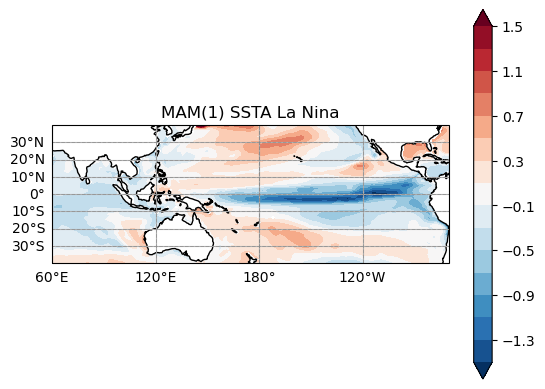

In [30]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
mam_SSTA.where(mam_SSTA.time == la_nina_shifted.time, drop = True).mean('time').plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1.5, vmax = 1.5, levels = 16, cmap = "RdBu_r")
ax.set_title('MAM(1) SSTA La Nina')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

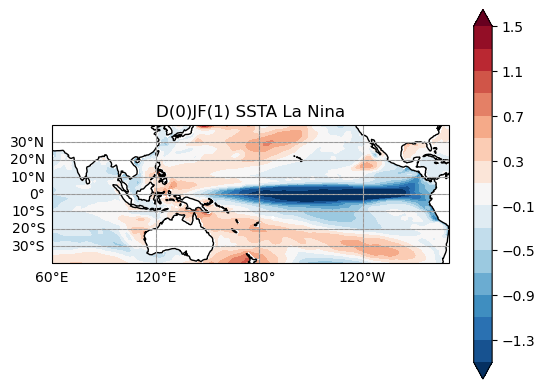

In [31]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
djf_SSTA.where(djf_SSTA.time == la_nina.time, drop = True).mean('time').plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1.5, vmax = 1.5, levels = 16, cmap = "RdBu_r", extend = 'both')
ax.set_title('D(0)JF(1) SSTA La Nina')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

In [32]:
#now use NNI to make SSTa composite and perform regression
NNI = Ningaloo2(ctrl)

In [33]:
NNmam=get_mam_mn(NNI)
strengthNN = NNmam.std()
cold = NNmam.where(NNmam<-1*strengthNN, drop = True)
warm = NNmam.where(NNmam>strengthNN, drop = True)

In [34]:
#get the JFM SSTA
def get_jfm(ds):
    return ds.sel(time=ds['time.month'].isin([1,2,3])).groupby('time.year').mean('time')

In [35]:
ssta_JFM = get_jfm(ssta(ctrl))

In [36]:
NNjfm=get_jfm(NNI)
strengthNNjfm = NNjfm.std()
coldj = NNjfm.where(NNjfm<-1*strengthNNjfm, drop = True)
warmj = NNjfm.where(NNjfm>strengthNNjfm, drop = True)

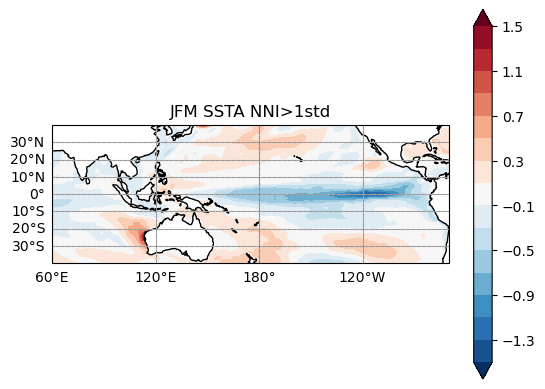

In [37]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ssta_JFM.where(ssta_JFM.year == warmj.year, drop = True).mean('year').plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1.5, vmax = 1.5, levels = 16, cmap = "RdBu_r")
ax.set_title('JFM SSTA NNI>1std')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

In [38]:
warm.groupby('time.year').mean('time').year

<xarray.DataArray 'year' (year: 22)>
array([ 960,  963,  970,  975,  978,  986, 1001, 1011, 1017, 1023, 1031, 1033,
       1036, 1055, 1063, 1078, 1079, 1080, 1082, 1085, 1087, 1098])
Coordinates:
  * year     (year) int64 960 963 970 975 978 986 ... 1080 1082 1085 1087 1098

In [39]:
NNI_3m = NNI.resample(time="QS-DEC").mean()

In [40]:
NNI_3m

<xarray.DataArray (time: 585)>
array([-9.13917303e-01, -1.09406531e+00, -4.60805893e-01, -2.02674136e-01,
       -4.71333973e-02, -3.93178195e-01, -2.75123447e-01, -1.92573324e-01,
       -5.36690235e-01,  3.96938413e-01,  6.58109367e-01,  1.76558018e-01,
        7.19481632e-02,  5.76955862e-02, -4.37196344e-01,  5.32075055e-02,
        1.04043055e+00,  2.18137547e-01, -6.20305002e-01, -4.00418788e-01,
        7.99339533e-01,  1.06576025e+00,  9.06901807e-03, -6.89352378e-02,
       -1.18923867e+00, -1.64938033e+00, -4.07941014e-01, -3.89157623e-01,
       -8.69924545e-01, -3.39200348e-01,  1.80858254e-01, -1.16985910e-01,
        3.88174504e-01,  1.07573462e+00,  2.85475194e-01,  7.30234236e-02,
        4.68280405e-01,  3.93531770e-01, -5.03586121e-02, -1.62160292e-01,
        4.44315463e-01,  5.38151503e-01,  5.11826217e-01,  2.48024151e-01,
       -3.31189185e-01, -1.20822592e-02,  5.43694980e-02,  2.51899183e-01,
        1.43617761e+00,  5.38289249e-01,  1.30848363e-01,  4.52746302e-02,
        5.52419066e-01,  4.26386565e-01,  4.75857466e-01,  3.18136543e-01,
        1.94585621e-02, -3.13217193e-01, -2.24483609e-01,  1.20595274e-02,
        2.10330769e-01,  9.74908113e-01,  2.90548533e-01,  4.02106680e-02,
        1.80403769e-01, -5.30181587e-01, -6.72515869e-01, -4.80058640e-01,
       -4.76485223e-01,  2.75780350e-01, -8.20494652e-01, -6.14001036e-01,
       -6.07624292e-01, -4.60591875e-02,  2.85620126e-03,  2.01256033e-02,
       -2.02218533e-01, -5.22629857e-01, -1.57748267e-01,  8.31131861e-02,
...
        2.35492345e-02,  6.76255941e-01,  1.94771990e-01,  1.70236483e-01,
       -1.47072002e-01,  1.48352146e-01,  4.99572515e-01,  2.96668917e-01,
        4.39950705e-01, -1.98667303e-01, -2.12154582e-01, -2.74395108e-01,
        1.06055987e+00,  8.94841433e-01,  6.64671123e-01,  2.95520931e-01,
       -6.13635898e-01, -7.24591792e-01, -6.39793575e-02,  2.33113095e-01,
        4.05888110e-01,  7.23599613e-01, -6.10056520e-02, -2.69459397e-01,
       -4.63949680e-01, -1.96260870e-01, -2.95058578e-01, -1.66129526e-02,
        4.91280109e-01,  2.33239487e-01, -1.72013715e-02,  3.25342774e-01,
        4.10749465e-01,  4.43019658e-01,  1.54016122e-01,  2.42298603e-01,
        7.44072735e-01,  5.28690100e-01, -8.60192776e-01, -3.48603129e-01,
       -6.83818281e-01,  1.15025938e-01,  1.82535902e-01, -7.70744756e-02,
       -8.44124496e-01, -1.10294610e-01,  1.04312897e-01,  1.62434891e-01,
        7.50943840e-01,  2.03835011e-01, -1.55852959e-01, -5.51982820e-01,
       -3.52301955e-01,  3.19511630e-02, -5.76210506e-02, -1.19215669e-02,
       -5.16970903e-02, -6.79035187e-02, -2.51001269e-01, -1.59075633e-01,
        4.51177448e-01,  4.32984084e-01,  4.35202330e-01,  1.68433830e-01,
        6.14453971e-01,  1.11249292e+00,  6.22288525e-01,  3.04422110e-01,
       -1.73685610e-01, -7.74878338e-02,  8.66746381e-02, -7.31761754e-02,
        2.96691895e-01, -1.99595228e-01, -8.36308002e-01, -4.43340950e-02,
       -1.53334939e-03], dtype=float32)
Coordinates:
  * time     (time) object 0954-12-01 00:00:00 ... 1100-12-01 00:00:00

In [41]:
NNI.resample(time="QS-JAN").mean()

<xarray.DataArray (time: 584)>
array([-1.17360973e+00, -7.03636646e-01, -3.84365201e-01, -1.29049942e-01,
       -1.01665914e-01, -3.56452495e-01, -4.09011841e-01, -1.53024629e-01,
       -3.58322710e-01,  5.38493216e-01,  5.67221344e-01,  6.43560067e-02,
        2.20309675e-01, -2.58147091e-01, -4.15542275e-01,  5.01461744e-01,
        9.48131323e-01, -9.67571959e-02, -7.51438916e-01, -1.82941914e-01,
        1.44073403e+00,  5.38782060e-01, -1.07124329e-01, -2.97265738e-01,
       -1.55337346e+00, -1.19511425e+00, -3.53211194e-01, -3.61226231e-01,
       -1.27195776e+00,  2.93892652e-01,  1.94034074e-02, -3.54077783e-03,
        6.85894907e-01,  8.27892065e-01,  1.49332419e-01,  8.89992714e-02,
        5.75787127e-01,  2.42725268e-01, -2.35678349e-02, -2.00896099e-01,
        6.25075638e-01,  6.74603045e-01,  2.71710455e-01,  2.22796157e-01,
       -3.30854297e-01, -4.82314415e-02,  1.55674234e-01,  4.26705837e-01,
        1.61869943e+00,  1.11253530e-01,  1.56761855e-01,  1.69517100e-01,
        5.25562048e-01,  4.09094840e-01,  4.96973544e-01,  3.85135919e-01,
       -1.92658141e-01, -4.23486441e-01, -7.98269883e-02, -8.24551657e-02,
        7.82824278e-01,  5.93092740e-01,  2.63176769e-01,  5.48471324e-02,
       -5.80537617e-02, -6.34555757e-01, -6.52648866e-01, -3.45869571e-01,
       -1.67132452e-01, -1.77344427e-01, -8.35371554e-01, -6.08972490e-01,
       -5.30158281e-01,  7.00106099e-02,  5.54791056e-02, -2.81757768e-02,
       -3.02079678e-01, -5.63308299e-01,  1.33072538e-02,  1.97551444e-01,
...
        4.87928718e-01,  3.67796630e-01,  1.61247626e-01,  1.00623392e-01,
       -9.94796753e-02,  3.03463608e-01,  4.75947946e-01,  1.67087451e-01,
        1.72476411e-01, -7.61639252e-02, -1.92425445e-01,  9.12966728e-02,
        1.12971723e+00,  8.40036213e-01,  5.25869131e-01,  3.30697186e-02,
       -8.35725486e-01, -4.23220485e-01, -7.63268992e-02,  4.09065843e-01,
        6.35934353e-01,  4.15244073e-01, -2.29720011e-01, -2.52240032e-01,
       -3.23522180e-01, -3.35539222e-01, -2.45380938e-01,  6.99603856e-02,
        4.74840909e-01,  2.14562044e-01,  6.93203062e-02,  1.61665022e-01,
        6.48043573e-01,  3.50085258e-01,  1.36843517e-01,  3.34652185e-01,
        8.82108212e-01,  3.76733136e-03, -8.46647322e-01, -2.29637563e-01,
       -7.34687150e-01,  3.98225635e-01,  7.98915252e-02, -3.37242514e-01,
       -7.78440535e-01,  1.54290676e-01,  6.61619008e-02,  3.24954838e-01,
        7.91044295e-01, -6.73655942e-02, -3.17166805e-01, -4.15867925e-01,
       -3.76825660e-01,  1.00345455e-01, -9.79322270e-02,  1.73383340e-01,
       -2.28572085e-01, -1.39851674e-01, -2.06362948e-01,  1.96749400e-02,
        4.48237658e-01,  4.92745250e-01,  3.74088407e-01,  1.08694710e-01,
        1.17014635e+00,  7.26651609e-01,  4.97448593e-01,  1.91162646e-01,
       -1.64776281e-01,  2.65655428e-04,  6.08015060e-02, -9.91864204e-02,
        3.66405696e-01, -6.86308920e-01, -5.33993900e-01,  5.44496141e-02],
      dtype=float32)
Coordinates:
  * time     (time) object 0955-01-01 00:00:00 ... 1100-10-01 00:00:00

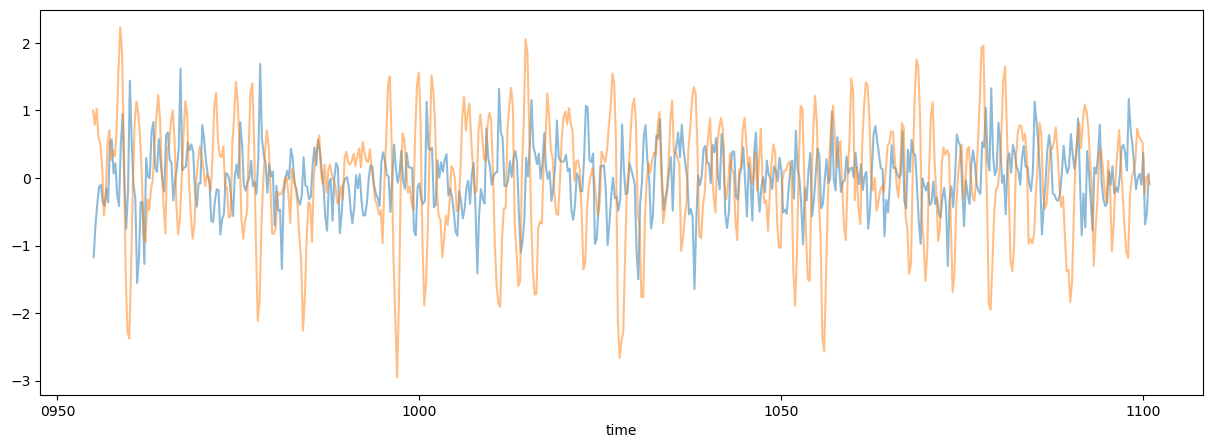

In [42]:
plt.figure(figsize = (15,5))
NNI.resample(time="QS-JAN").mean().plot(alpha = 0.5)
#NNI_3m.plot(alpha = 0.5)
n34.resample(time="QS-DEC").mean().plot(alpha = 0.5)
#warm.plot.scatter()
#warmj.plot.scatter()

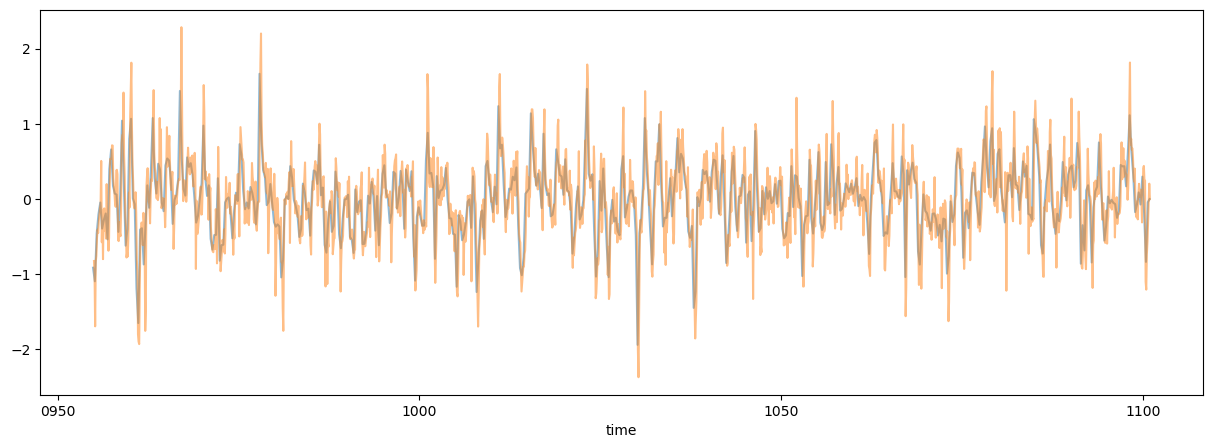

In [43]:
plt.figure(figsize = (15,5))

NNI_3m.plot(alpha = 0.5)
NNI.plot(alpha = 0.5)

In [44]:
warmj.year

<xarray.DataArray 'year' (year: 21)>
array([ 959,  960,  963,  967,  970,  978, 1001, 1011, 1019, 1023, 1028, 1052,
       1057, 1063, 1079, 1080, 1085, 1090, 1091, 1094, 1098])
Coordinates:
  * year     (year) int64 959 960 963 967 970 978 ... 1085 1090 1091 1094 1098

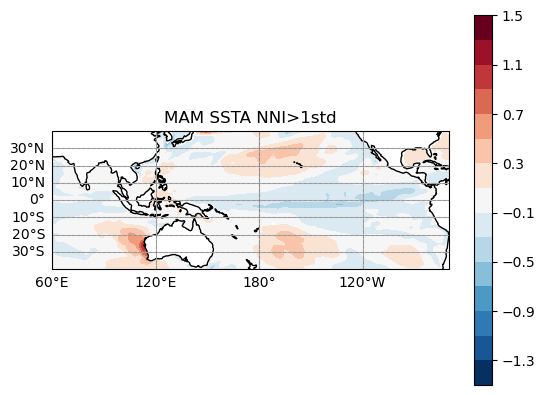

In [45]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
mam_SSTA.where(mam_SSTA.time == warm.time, drop = True).mean('time').plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1.5, vmax = 1.5, levels = 16, cmap = "RdBu_r")
ax.set_title('MAM SSTA NNI>1std')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

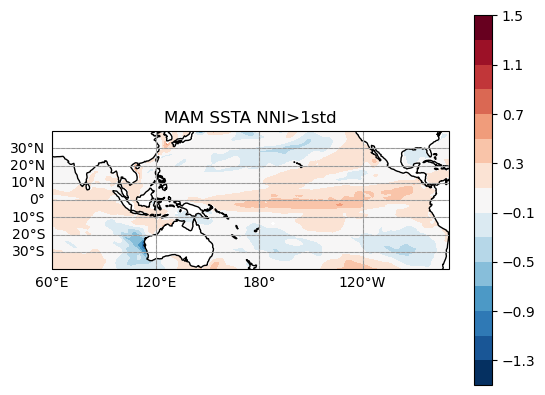

In [46]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
mam_SSTA.where(mam_SSTA.time == cold.time, drop = True).mean('time').plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1.5, vmax = 1.5, levels = 16, cmap = "RdBu_r")
ax.set_title('MAM SSTA NNI>1std')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

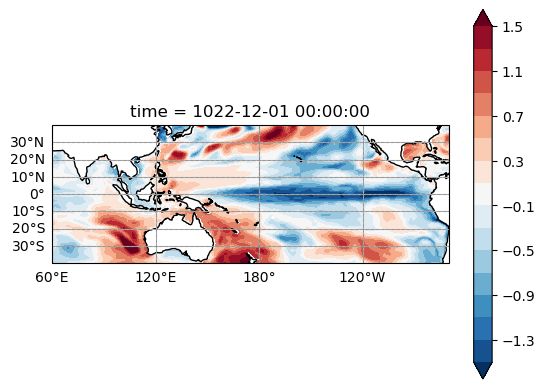

In [47]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
djf_SSTA[68].plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1.5, vmax = 1.5, levels = 16, cmap = "RdBu_r")
#ax.set_title('MAM SSTA NNI>1std')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

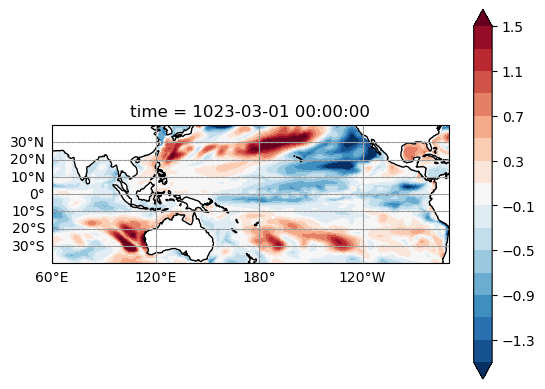

In [48]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
mam_SSTA.where(mam_SSTA.time == warm.time, drop = True)[9].plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1.5, vmax = 1.5, levels = 16, cmap = "RdBu_r")
#ax.set_title('MAM SSTA NNI>1std')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

In [49]:
#regress Ningaloo Nino onto the SSTA

In [50]:
from sklearn.linear_model import LinearRegression


In [51]:
def linear_trend(x, y):
    pf = np.polyfit(x, y, 1)
    return xr.DataArray(pf[0])

In [52]:
def regress(var1, var2):
    slope = xr.apply_ufunc(linear_trend,
                        var1, var2,
                        vectorize=True,
                        dask = 'parallelized',
                        input_core_dims=[['time'], ['time']],# reduce along 'model'
                        )
    return slope

In [ ]:
regr = LinearRegression().fit(DS[list(DS.keys())[0]][:,month].values.reshape(-1, 1),
                                  DS[list(DS.keys())[1]][:, month].values.reshape(-1, 1))

In [53]:
slope = regress(NNI, ssta(ctrl))

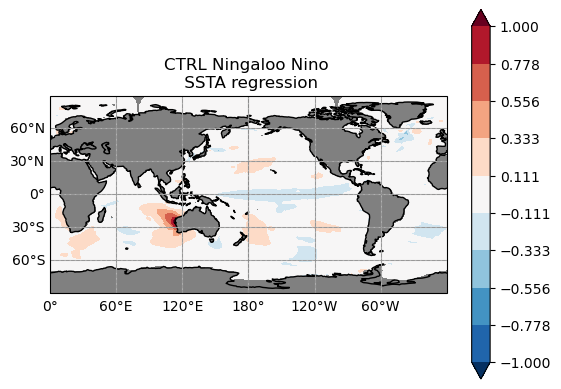

In [54]:

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('CTRL Ningaloo Nino \n SSTA regression')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

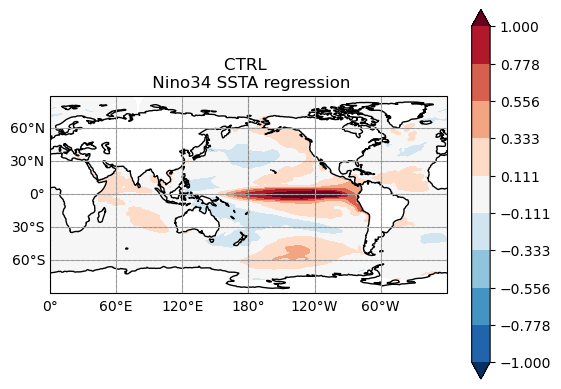

In [55]:
slope = regress(n34, ssta(ctrl))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('CTRL \n Nino34 SSTA regression')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

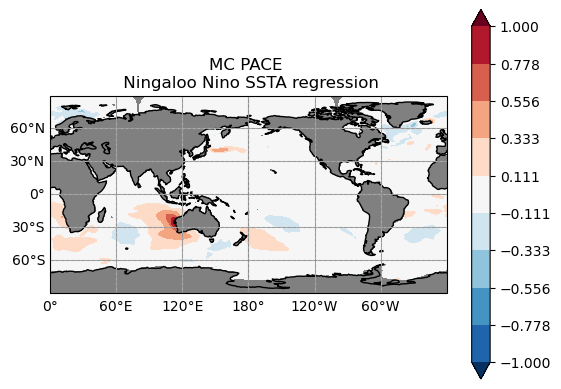

In [56]:
slope = regress(Ningaloo2(PO_PACE), ssta(PO_PACE))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('MC PACE \n Ningaloo Nino SSTA regression')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

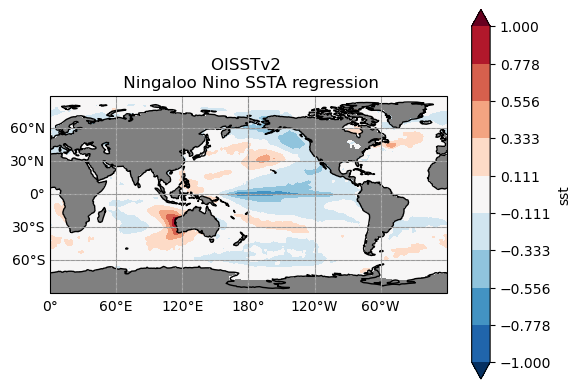

In [57]:
slope = regress(Ningaloo2(OBS), ssta(OBS))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('OISSTv2 \n Ningaloo Nino SSTA regression')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

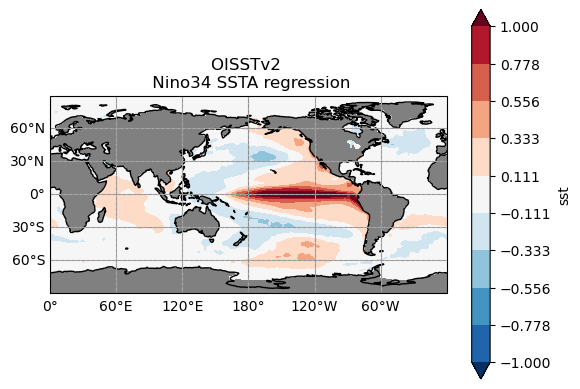

In [58]:
slope = regress(NINO34(OBS), ssta(OBS))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('OISSTv2 \n Nino34 SSTA regression')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

In [59]:
#IOD regression

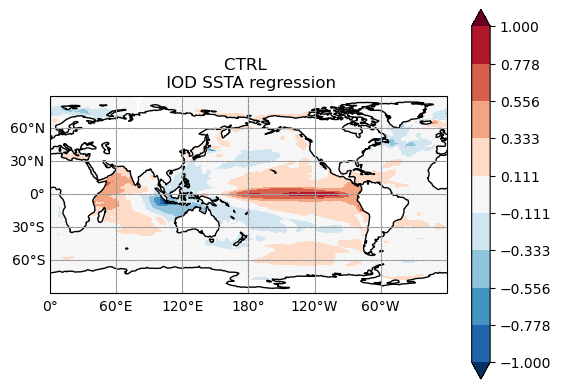

In [60]:
slope = regress(dmi(ctrl), ssta(ctrl))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('CTRL \n IOD SSTA regression')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

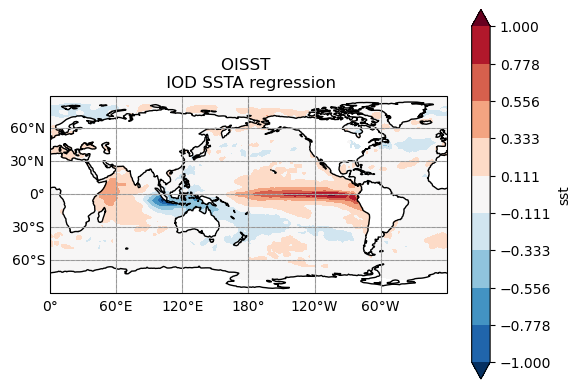

In [61]:
slope = regress(dmi(OBS), ssta(OBS))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('OISST \n IOD SSTA regression')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

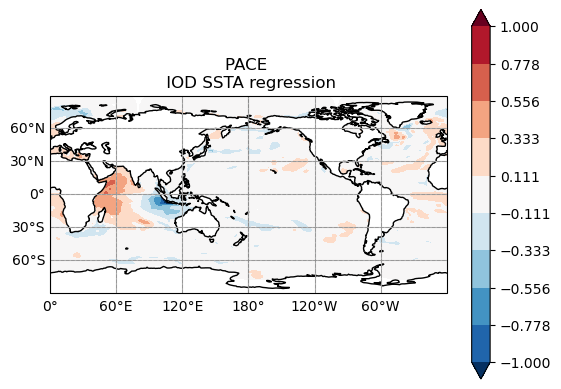

In [62]:
slope = regress(dmi(PO_PACE), ssta(PO_PACE))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

slope.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, extend = 'both',  cmap = "RdBu_r")
ax.set_title('PACE \n IOD SSTA regression')
ax.coastlines(color = 'k')
ax.gridlines()
#ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

In [63]:
#look at Lead lag correlation
from scipy.signal import correlate,correlation_lags
from scipy.stats import pearsonr

In [64]:
lags = correlation_lags(Ningaloo2(ctrl).size, NINO34(ctrl).size, mode="full")
corr = correlate(NINO34(ctrl),Ningaloo2(ctrl))
corr /= corr[Ningaloo2(ctrl).size - 1]
lag = lags[np.argmax(corr)]

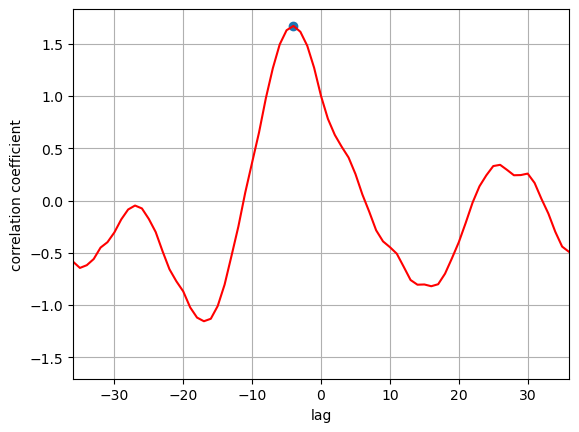

In [65]:
fig, ax = plt.subplots()
ax.plot(lags, corr, 'r')
ax.set_xlabel('lag')
ax.set_ylabel('correlation coefficient')
ax.grid(True)
ax.set_xlim(-36,36)
ax.scatter(lag, max(corr))

Text(0.5, 1.0, 'OISSTV2 lagged corr')

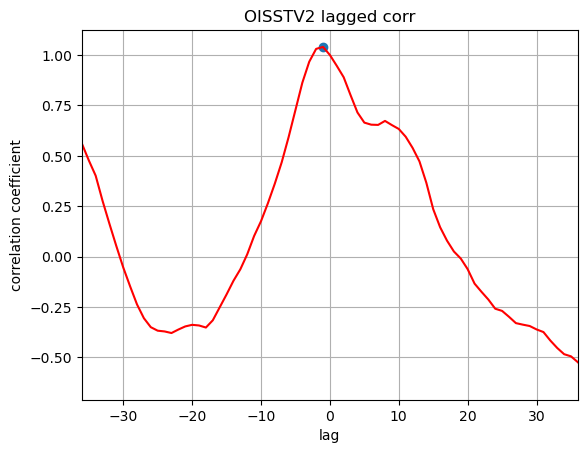

In [68]:
lags = correlation_lags(NINO34(OBS).size, Ningaloo2(OBS).size, mode="full")
corr = correlate(NINO34(OBS),Ningaloo2(OBS))
corr /= corr[Ningaloo2(OBS).size - 1]
lag = lags[np.argmax(corr)]
fig, ax = plt.subplots()
ax.plot(lags, corr, 'r')
ax.set_xlabel('lag')
ax.set_ylabel('correlation coefficient')
ax.grid(True)
ax.set_xlim(-36,36)
ax.scatter(lag, max(corr))
ax.set_title("OISSTV2 lagged corr")

In [ ]:
#lagged corr of IOD and ENSO

Text(0.5, 1.0, 'OISSTV2 lagged corr')

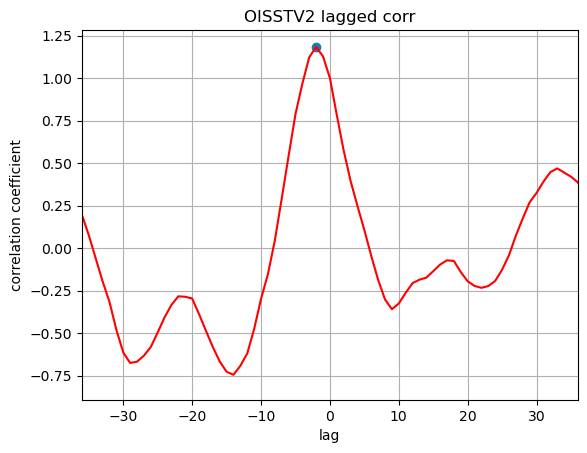

In [70]:
lags = correlation_lags(dmi(OBS).size, NINO34(OBS).size, mode="full")
corr = correlate(dmi(OBS),NINO34(OBS))
corr /= corr[NINO34(OBS).size - 1]
lag = lags[np.argmax(corr)]
fig, ax = plt.subplots()
ax.plot(lags, corr, 'r')
ax.set_xlabel('lag')
ax.set_ylabel('correlation coefficient')
ax.grid(True)
ax.set_xlim(-36,36)
ax.scatter(lag, max(corr))
ax.set_title("OISSTV2 lagged corr")

Text(0.5, 1.0, 'ctrl lagged corr')

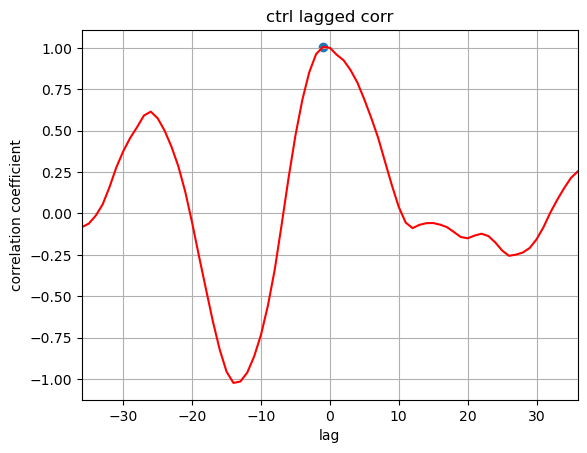

In [73]:
lags = correlation_lags(dmi(ctrl).size, NINO34(ctrl).size, mode="full")
corr = correlate(dmi(ctrl),NINO34(ctrl))
corr /= corr[NINO34(ctrl).size - 1]
lag = lags[np.argmax(corr)]
fig, ax = plt.subplots()
ax.plot(lags, corr, 'r')
ax.set_xlabel('lag')
ax.set_ylabel('correlation coefficient')
ax.grid(True)
ax.set_xlim(-36,36)
ax.scatter(lag, max(corr))
ax.set_title("ctrl lagged corr")

In [71]:
lag

-2

In [ ]:
Ningaloo2(OBS)

In [ ]:
def corrcoef_func(x, y):
    x, y = np.nan_to_num(x), np.nan_to_num(y)
    r,p =  pearsonr(x, y)
    return r,p

In [181]:
corr_coef, pvals = np.apply_along_axis(corrcoef_func, axis=0, arr=ssta(OBS), y=Ningaloo2(OBS))

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [183]:
def convert_to_da(arr):
    arr_xr = xr.DataArray(arr, 
                    coords={'latitude': ctrl.latitude, 'longitude': ctrl.longitude}, 
                    dims=["latitude", "longitude"])
    return arr_xr

In [184]:
corr_coef = convert_to_da(corr_coef)
pvals = convert_to_da(pvals)

In [186]:
def calc_pearsonr(arr, index):
    corr_coef, pvals = np.apply_along_axis(corrcoef_func, axis=0, arr=arr, y=index)
    corr_coef = convert_to_da(corr_coef)
    pvals = convert_to_da(pvals)
    return corr_coef, pvals

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


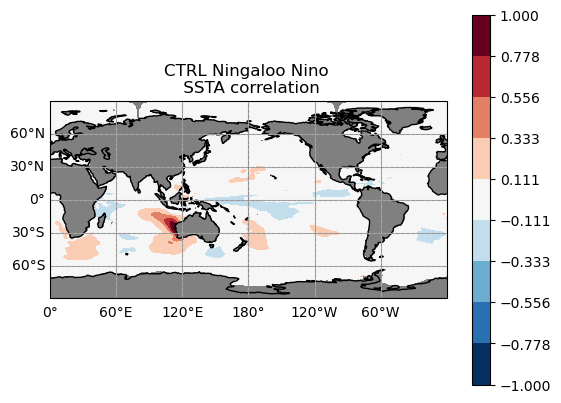

In [193]:
r,p = calc_pearsonr(ssta(ctrl), Ningaloo2(ctrl))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

r.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10,  cmap = "RdBu_r")
ax.set_title('CTRL Ningaloo Nino \n SSTA correlation')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


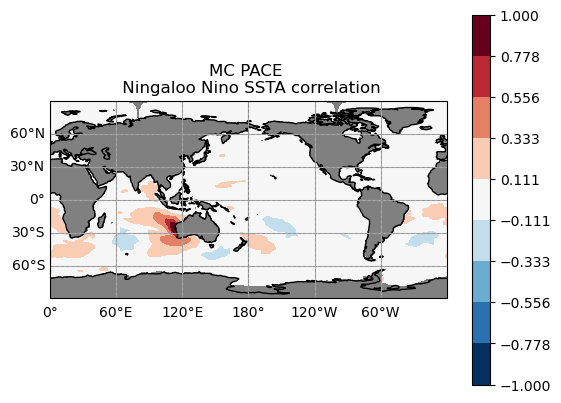

In [194]:
r,p = calc_pearsonr(ssta(PO_PACE), Ningaloo2(PO_PACE))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

r.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10,  cmap = "RdBu_r")
ax.set_title('MC PACE \n Ningaloo Nino SSTA correlation')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


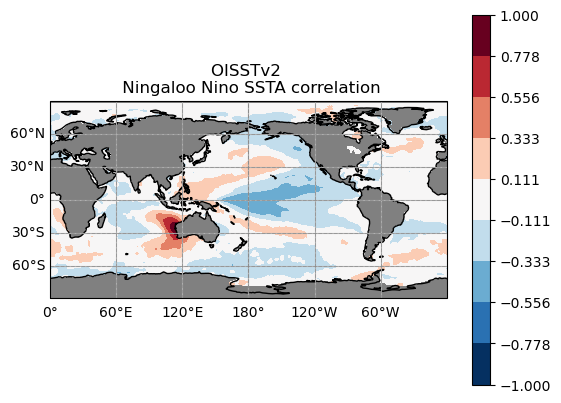

In [195]:
r,p = calc_pearsonr(ssta(OBS), Ningaloo2(OBS))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

r.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
                        vmin = -1, vmax = 1, levels = 10, cmap = "RdBu_r")
ax.set_title('OISSTv2 \n Ningaloo Nino SSTA correlation')
ax.coastlines(color = 'k')
ax.gridlines()
ax.set_facecolor('grey')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
#ax.set_extent([60, 290, -40, 40], crs=ccrs.PlateCarree())

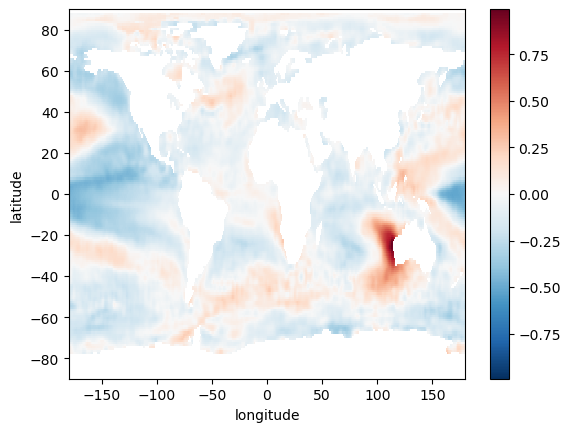

In [185]:
corr_coef.plot()

In [197]:
###Lets get evolution of typical events. Write a fucntion to get the months correctly. 
NNI = Ningaloo2(OBS)
SSTAO = ssta(OBS)

In [211]:
#Assume NN peaks in JFM
#look at seasons JAS(-1), OND(-1), JFM(0), AMJ(0)
#resample to 3 monthly timestpes
NNI_ = NNI.resample(time="QS-JAN").mean()
NNI_JFM = NNI_.sel(time=NNI_['time.month'].isin([1,2,3]))

In [207]:
NNI_.where(abs(NNI_) > 0.7).dropna('time')

<xarray.DataArray 'sst' (time: 45)>
array([ 0.71671134,  0.71484447,  0.9990112 ,  0.7829413 , -0.85050756,
       -0.9298775 , -0.7323366 , -0.8568998 , -0.7246742 ,  0.86151123,
        0.9671078 ,  0.7250447 ,  0.8125481 ,  0.859011  , -0.9368963 ,
        0.77095556, -0.882174  , -1.3324522 , -0.96765524,  0.81294113,
        1.1165113 ,  0.7414368 ,  1.4984555 ,  0.8351634 ,  1.0481002 ,
        1.4178258 , -0.7238441 , -0.75301105, -1.0402297 , -1.0666218 ,
       -0.7068965 ,  0.7789368 ,  1.4378223 ,  2.216159  ,  1.3361591 ,
        1.2978258 , -1.2482109 , -0.7212255 , -0.8226144 , -0.8301554 ,
       -1.1926142 , -1.2138442 , -1.2796742 , -0.8454334 , -0.8870588 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1982-10-01 1983-04-01 ... 2019-07-01

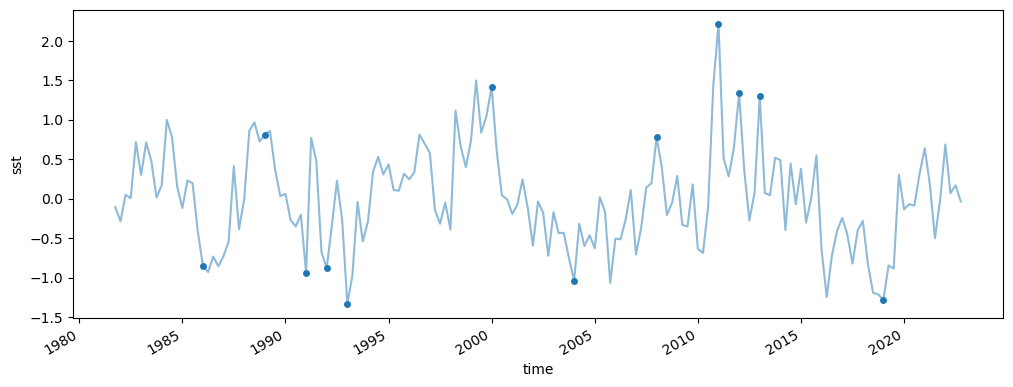

In [212]:
#get times when event is on
plt.figure(figsize = (12,4))
NNI_.plot(alpha = 0.5)
NNI_JFM.where(abs(NNI_JFM) > NNI_JFM.std()).dropna('time').plot.scatter()

In [213]:
cold = NNI_JFM.where(NNI_JFM<-1*NNI_JFM.std(), drop = True)
warm = NNI_JFM.where(NNI_JFM>NNI_JFM.std(), drop = True)

In [217]:
#shift the la Nina years so that the year matches up

# Get the original time values as a numpy array
time_values = warm['time'].values

# Create a new array with shifted times shift y
time_shifted_values = []
for time in time_values:
    print(time)
    ond_shift = cftime.DatetimeGregorian(year=time.year-1, month=time.month+9, day=time.day,
                                         hour=time.hour, minute=time.minute, second=time.second)
    time_shifted_values.append(ond_shift)
time_shifted_values = xr.DataArray(time_shifted_values, dims='time', coords={'time': la_nina['time']})
#la_nina_shifted = la_nina.assign_coords({'time': time_shifted_values})

1989-01-01T00:00:00.000000000


AttributeError: 'numpy.datetime64' object has no attribute 'year'

In [254]:
warm['time'][0] -np.timedelta64(1, 'M')

UFuncTypeError: Cannot cast ufunc 'subtract' input 1 from dtype('<m8[M]') to dtype('<m8[ns]') with casting rule 'same_kind'

In [250]:
dt.timedelta(1,0)

datetime.timedelta(days=1)

In [257]:
warm.time[0]

<xarray.DataArray 'time' ()>
array('1989-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1989-01-01